# 3D Shape/Scene Captioning
## 0. settings

In [1]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
root = "/mnt/raid/davech2y/ShapeNetCore_vol/nrrd_256_filter_div_128/"
sizes = [
    [16, 2, 2],
    [32, 4, 4]
]

In [3]:
datasets = []
for i, size in enumerate(sizes):
    datasets.append(Caption(pandas.read_csv("captions.tablechair.csv"), size))
    print("[set %d]: total_size: %d, train_size: %d, valid_size: %d, test_size: %d, vocal_size: %d" 
          % (i+1, 
             datasets[-1].total_size, 
             datasets[-1].train_size, 
             datasets[-1].valid_size,
             datasets[-1].test_size,
             datasets[-1].dict_size))

[set 1]: total_size: 20, train_size: 16, valid_size: 2, test_size: 2, vocal_size: 132
[set 2]: total_size: 40, train_size: 32, valid_size: 4, test_size: 4, vocal_size: 175


## 1. 2D encoder-decoder for image captioning

In [4]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

train_log = []
models = []
for data in datasets:
    print("[Info] train_size: %d, valid_size: %d, dict_size: %d\n" % 
          (data.train_size, data.valid_size, data.dict_size))
    
    # prepare the dataloader
    transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
    train_ds = ImageCaptionDataset(root, data.transformed_data['train'], transform)
    train_dl = DataLoader(train_ds, batch_size=50)
    valid_ds = ImageCaptionDataset(root, data.transformed_data['valid'], transform)
    valid_dl = DataLoader(valid_ds, batch_size=50)
    dataloader = {
        'train': train_dl,
        'valid': valid_dl
    }

    # # load the pretrained encoder
    # encoder = torch.load("data/encoder.pth").cuda()

    # initialize the encoder
    encoder = Encoder2D().cuda()

    # define the decoder
    input_size = data.dict_size + 1
    hidden_size = 512
    num_layer = 2
    decoder = Decoder(input_size, hidden_size, num_layer).cuda()

    # prepare the training parameters
    # optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
    params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    epoch = 500
    verbose = 10

    # training
    encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion, model_type="2d")
    encoder_decoder_solver.train(encoder, decoder, dataloader, data.corpus, data.dict_idx2word, epoch, verbose)
    
    # save
    train_log.append(encoder_decoder_solver.log)
    models.append((encoder, decoder))
    torch.save(encoder, "data/encoder_%s_ts%d_e%d_lr%f_bs%d_vocal%d.pth"  % ("2d", data.train_size + data.valid_size, epoch, 0.0001, 50, input_size))
    torch.save(decoder, "data/decoder_%s_ts%d_e%d_lr%f_bs%d_vocal%d.pth"  % ("2d", data.train_size + data.valid_size, epoch, 0.0001, 50, input_size))
    print()

[Info] train_size: 16, valid_size: 2, dict_size: 132

---------------------epoch 10/500----------------------
[train] train_loss: 4.805148, train_blue: 0.503048
[valid] valid_loss: 4.785519, valid_blue: 0.555711
[Info]  forward_per_epoch: 0.007191s
[Info]  backward_per_epoch: 0.016457s
[Info]  valid_per_epoch: 0.016699s
[Info]  time_per_epoch: 0.373309s
[Info]  ETA: 3m 2s 

---------------------epoch 20/500----------------------
[train] train_loss: 4.654625, train_blue: 0.564857
[valid] valid_loss: 4.455422, valid_blue: 0.718608
[Info]  forward_per_epoch: 0.007161s
[Info]  backward_per_epoch: 0.016489s
[Info]  valid_per_epoch: 0.015797s
[Info]  time_per_epoch: 0.379241s
[Info]  ETA: 3m 2s 

---------------------epoch 30/500----------------------
[train] train_loss: 4.252887, train_blue: 0.654665
[valid] valid_loss: 3.969714, valid_blue: 0.661442
[Info]  forward_per_epoch: 0.009126s
[Info]  backward_per_epoch: 0.020784s
[Info]  valid_per_epoch: 0.016333s
[Info]  time_per_epoch: 0.394962

---------------------epoch 270/500----------------------
[train] train_loss: 0.269231, train_blue: 0.981899
[valid] valid_loss: 6.123923, valid_blue: 0.530777
[Info]  forward_per_epoch: 0.007344s
[Info]  backward_per_epoch: 0.018368s
[Info]  valid_per_epoch: 0.015940s
[Info]  time_per_epoch: 0.367223s
[Info]  ETA: 1m 24s 

---------------------epoch 280/500----------------------
[train] train_loss: 0.250174, train_blue: 0.980042
[valid] valid_loss: 6.178199, valid_blue: 0.530777
[Info]  forward_per_epoch: 0.007168s
[Info]  backward_per_epoch: 0.020430s
[Info]  valid_per_epoch: 0.015936s
[Info]  time_per_epoch: 0.369087s
[Info]  ETA: 1m 21s 

---------------------epoch 290/500----------------------
[train] train_loss: 0.233785, train_blue: 0.980470
[valid] valid_loss: 6.228213, valid_blue: 0.530777
[Info]  forward_per_epoch: 0.007175s
[Info]  backward_per_epoch: 0.017423s
[Info]  valid_per_epoch: 0.015767s
[Info]  time_per_epoch: 0.386400s
[Info]  ETA: 1m 21s 

---------------------epoc

---------------------epoch 30/500----------------------
[train] train_loss: 4.419880, train_blue: 0.438481
[valid] valid_loss: 4.862511, valid_blue: 0.581694
[Info]  forward_per_epoch: 0.012100s
[Info]  backward_per_epoch: 0.022885s
[Info]  valid_per_epoch: 0.022227s
[Info]  time_per_epoch: 0.716151s
[Info]  ETA: 5m 36s 

---------------------epoch 40/500----------------------
[train] train_loss: 4.112756, train_blue: 0.456718
[valid] valid_loss: 5.125494, valid_blue: 0.555721
[Info]  forward_per_epoch: 0.008688s
[Info]  backward_per_epoch: 0.019864s
[Info]  valid_per_epoch: 0.021795s
[Info]  time_per_epoch: 0.695919s
[Info]  ETA: 5m 20s 

---------------------epoch 50/500----------------------
[train] train_loss: 3.861281, train_blue: 0.431617
[valid] valid_loss: 5.109168, valid_blue: 0.555721
[Info]  forward_per_epoch: 0.008876s
[Info]  backward_per_epoch: 0.021784s
[Info]  valid_per_epoch: 0.023668s
[Info]  time_per_epoch: 0.719479s
[Info]  ETA: 5m 23s 

---------------------epoch 6

---------------------epoch 290/500----------------------
[train] train_loss: 0.367284, train_blue: 0.983120
[valid] valid_loss: 7.673467, valid_blue: 0.625710
[Info]  forward_per_epoch: 0.008759s
[Info]  backward_per_epoch: 0.020557s
[Info]  valid_per_epoch: 0.021725s
[Info]  time_per_epoch: 0.717854s
[Info]  ETA: 2m 30s 

---------------------epoch 300/500----------------------
[train] train_loss: 0.338984, train_blue: 0.985884
[valid] valid_loss: 7.732186, valid_blue: 0.625710
[Info]  forward_per_epoch: 0.008786s
[Info]  backward_per_epoch: 0.020519s
[Info]  valid_per_epoch: 0.021953s
[Info]  time_per_epoch: 0.701137s
[Info]  ETA: 2m 20s 

---------------------epoch 310/500----------------------
[train] train_loss: 0.314278, train_blue: 0.985884
[valid] valid_loss: 7.848243, valid_blue: 0.625710
[Info]  forward_per_epoch: 0.008755s
[Info]  backward_per_epoch: 0.021389s
[Info]  valid_per_epoch: 0.027734s
[Info]  time_per_epoch: 0.709765s
[Info]  ETA: 2m 14s 

---------------------epoc

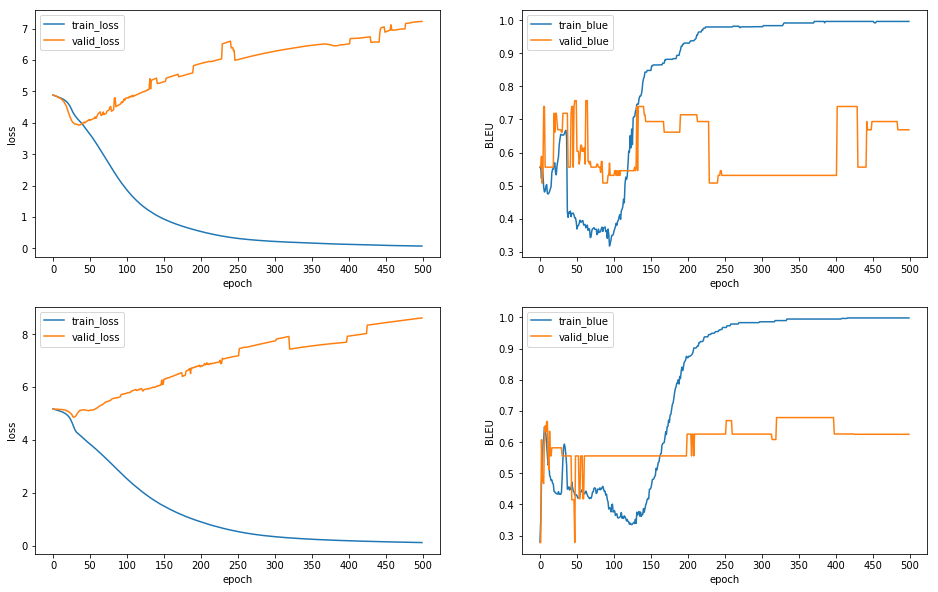

In [18]:
# plot the result
fig = plt.gcf()
fig.set_size_inches(16,10)
for i in range(2):
    plt.subplot(2, 2, i * 2 + 1)
    plt.plot(range(epoch), [train_log[i][j]["train_loss"] for j in range(epoch)], label="train_loss")
    plt.plot(range(epoch), [train_log[i][j]["valid_loss"] for j in range(epoch)], label="valid_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    plt.subplot(2, 2, i * 2 + 2)
    plt.plot(range(epoch), [train_log[i][j]["train_blue"] for j in range(epoch)], label="train_blue")
    plt.plot(range(epoch), [train_log[i][j]["valid_blue"] for j in range(epoch)], label="valid_blue")
    plt.xlabel('epoch')
    plt.ylabel('BLEU')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
    
plt.show()

In [4]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_checkpoint_2d.pth"
decoder_path = "data/decoder_checkpoint_2d.pth"
encoder_decoder = EncoderDecoder(encoder_path, decoder_path)

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = ImageCaptionDataset(root, datasets[-1].transformed_data['train'], transform)
dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

# caption images
descriptions = []
images = []
for i, (_, image_inputs, caps, cap_lengths) in enumerate(dataloader):
    image_inputs = Variable(image_inputs).cuda()
    descriptions += encoder_decoder.generate_text(image_inputs, datasets[-1].dict_idx2word, 50)
    images.append(image_inputs)

In [5]:
descriptions

['<START> classic design with contemporary style glass table . the base is steel coated legs . there is also a storage facility just below the top . the glass is attached through four bolts . <END>',
 '<START> a brown coloured chair with silver coloured coatings at the outer part . <END>',
 '<START> it is narrow console table . it is made from plywood . its size is quite good to place anything on it . it is grey in colour . <END>',
 '<START> panel based three cluster workstation having three nos . of semi-circular shaped workstation . it is blue and grey in colour . the base is of three legs <END>',
 '<START> a double cushion chair . the back rest cushion is larger than the seating rest . it is an arm chair . it is purple in colour . <END>',
 '<START> it is simple chiar with comfortable back rest and seating rest . the chair is floating between two arches of tough stainless steel legs . <END>',
 '<START> a stripped multi coloured chair with cream coloured seating , provided with four s

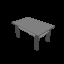

In [9]:
transforms.ToPILImage()(images[0].cpu().view(3, 64, 64))

## 2. 3D encoder-decoder for shape captioning

In [4]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

train_log = []
models = []
for data in datasets:
    print("[Info] train_size: %d, valid_size: %d, dict_size: %d\n" % 
          (data.train_size, data.valid_size, data.dict_size))
    
    # prepare the dataloader
    train_ds = ShapeCaptionDataset(root, data.transformed_data['train'])
    train_dl = DataLoader(train_ds, batch_size=2)
    valid_ds = ShapeCaptionDataset(root, data.transformed_data['valid'])
    valid_dl = DataLoader(valid_ds, batch_size=2)
    dataloader = {
        'train': train_dl,
        'valid': valid_dl
    }

    # # load the pretrained encoder
    # encoder = torch.load("data/encoder.pth").cuda()

    # initialize the encoder
    encoder = Encoder3D().cuda()

    # define the decoder
    input_size = data.dict_size + 1
    hidden_size = 512
    num_layer = 2
    decoder = Decoder(input_size, hidden_size, num_layer).cuda()

    # prepare the training parameters
    # optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
    params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    epoch = 200
    verbose = 10

    # training
    encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion, model_type="3d")
    encoder_decoder_solver.train(encoder, decoder, dataloader, data.corpus, data.dict_idx2word, epoch, verbose)
    
    # save
    train_log.append(encoder_decoder_solver.log)
    models.append((encoder, decoder))
    print()

[Info] train_size: 16, valid_size: 2, dict_size: 132

---------------------epoch 10/200----------------------
[train] train_loss: 3.639161, train_blue: 0.419150
[valid] valid_loss: 4.030988, valid_blue: 0.555711
[Info]  forward_per_epoch: 0.387667s
[Info]  backward_per_epoch: 0.991907s
[Info]  valid_per_epoch: 0.045639s
[Info]  time_per_epoch: 3.170727s
[Info]  ETA: 10m 2s 

---------------------epoch 20/200----------------------
[train] train_loss: 2.444641, train_blue: 0.324116
[valid] valid_loss: 4.450226, valid_blue: 0.576325
[Info]  forward_per_epoch: 0.391294s
[Info]  backward_per_epoch: 0.989466s
[Info]  valid_per_epoch: 0.045818s
[Info]  time_per_epoch: 3.172998s
[Info]  ETA: 9m 31s 

---------------------epoch 30/200----------------------
[train] train_loss: 1.636447, train_blue: 0.392832
[valid] valid_loss: 5.037533, valid_blue: 0.772563
[Info]  forward_per_epoch: 0.396409s
[Info]  backward_per_epoch: 0.984911s
[Info]  valid_per_epoch: 0.046448s
[Info]  time_per_epoch: 3.1868

KeyboardInterrupt: 

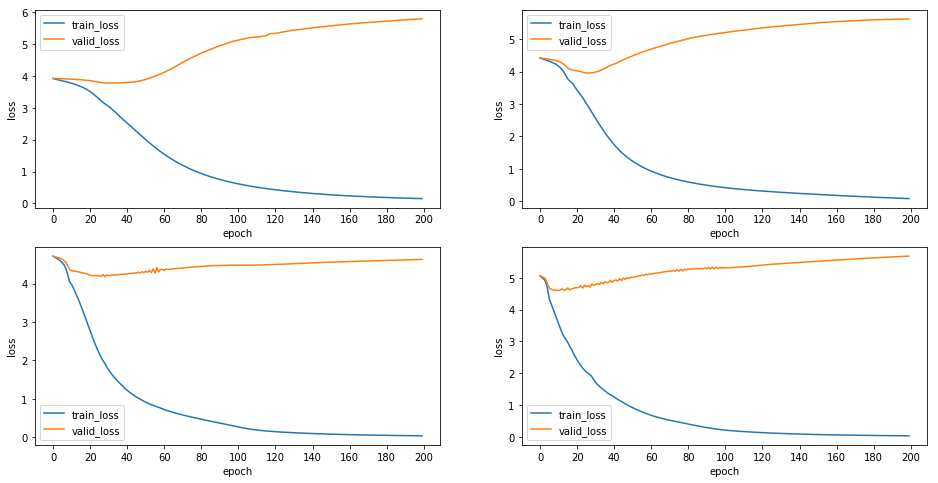

In [8]:
# plot the result
fig = plt.gcf()
fig.set_size_inches(16,8)
for i in range(len(train_log)):
    plt.subplot(math.ceil(len(train_log) / 2), 2, i + 1)
    plt.plot(range(epoch), [train_log[i][j]["train_loss"] for j in range(epoch)], label="train_loss")
    plt.plot(range(epoch), [train_log[i][j]["valid_loss"] for j in range(epoch)], label="valid_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, epoch + 1, math.floor(epoch / 10)))
    plt.legend()
plt.show()

In [4]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_checkpoint_3d.pth"
decoder_path = "data/decoder_checkpoint_3d.pth"
encoder_decoder = EncoderDecoder3D(encoder_path, decoder_path)

# prepare the dataloader
train_ds = ShapeCaptionDataset(root, train_captions[-1])
dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

# caption images
descriptions = []
images = []
for i, (image_inputs, caps, cap_lengths) in enumerate(dataloader):
    image_inputs = Variable(image_inputs).cuda()
    descriptions += encoder_decoder.generate_text(image_inputs, captions.dict_idx2word, 50)
    images.append(image_inputs)

In [5]:
descriptions

['<START> it is snooker table . it has four big bolt like legs with wheel . it is grey in colour . <END>',
 '<START> a grey sofa seat with leather seat and wire rack type of material <END>',
 '<START> it is narrow console table . it is made from plywood . its size is quite good to place anything on it . it is grey in colour . <END>',
 '<START> a grey sofa seat with leather seat and wire rack type of material <END>',
 '<START> a stylish brown coloured chair , provided with perfect supporings at the bottom . <END>',
 '<START> the table is round and has 3 legs . the table is rotating <END>',
 '<START> a black stylish table with round design provided at the centre of the table . <END>',
 '<START> a stylish brown coloured chair , provided with perfect supporings at the bottom . <END>',
 '<START> a light green coloured chair , useful for office purposes , provided with perfect supportings . <END>',
 '<START> a stylish coloured chair , with red coloured seating provided , with good design . <